In [14]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score
from flask import Flask, request, jsonify
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

ModuleNotFoundError: No module named 'flask'

SINCE WE DON'T HAVE A DATASET, WE'D HAVE TO SIMULATE A DATASET

In [7]:
# Generate users
num_users = 100
user_data = pd.DataFrame({
    'user_id': range(1, num_users + 1),
    'age': np.random.randint(18, 70, num_users),
    'location': np.random.choice(['Urban', 'Suburban', 'Rural'], num_users),
    'purchase_frequency': np.random.randint(1, 50, num_users)
})

# Generate products
num_products = 50
product_data = pd.DataFrame({
    'product_id': range(1, num_products + 1),
    'category': np.random.choice(['Electronics', 'Clothing', 'Home', 'Beauty'], num_products),
    'price': np.round(np.random.uniform(5.0, 500.0, num_products), 2),
    'popularity': np.random.randint(1, 100, num_products)
})

# Generate user-product interactions
interactions = []
for user in range(num_users):
    for _ in range(random.randint(1, 20)):  # each user interacts with 1-20 products
        product_id = random.choice(product_data['product_id'])
        interactions.append({
            'user_id': user + 1,
            'product_id': product_id,
            'interaction': random.choice(['view', 'add_to_cart', 'purchase'])
        })

interaction_data = pd.DataFrame(interactions)


DATA PREPROCESSING, WHICH HELPS TO ENCODE CATEGORICAL VALUES

In [8]:


# Encoding categorical variables
product_data['category'] = LabelEncoder().fit_transform(product_data['category'])
user_data['location'] = LabelEncoder().fit_transform(user_data['location'])

# Normalizing numeric features
scaler = MinMaxScaler()
product_data[['price', 'popularity']] = scaler.fit_transform(product_data[['price', 'popularity']])
user_data['purchase_frequency'] = scaler.fit_transform(user_data[['purchase_frequency']])

# Merge datasets for recommendation input
data = pd.merge(interaction_data, user_data, on='user_id')
data = pd.merge(data, product_data, on='product_id')


EXPLORATORY DATA ANALYSIS

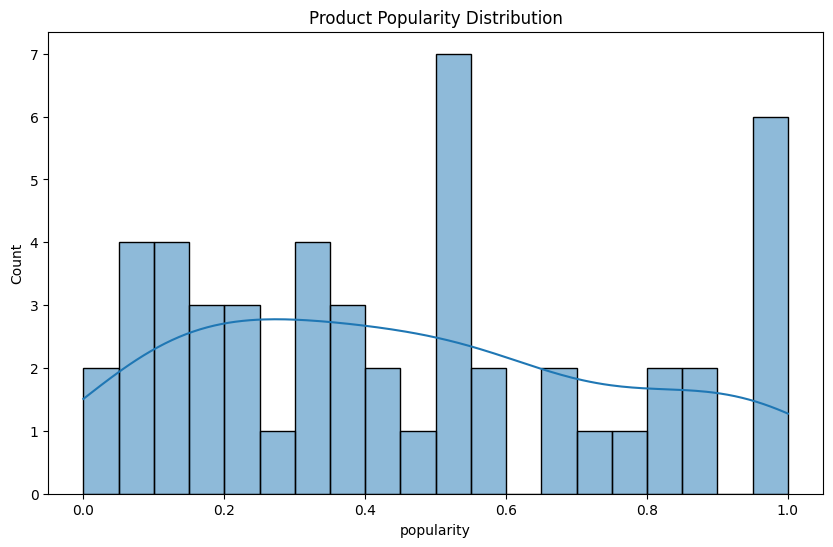

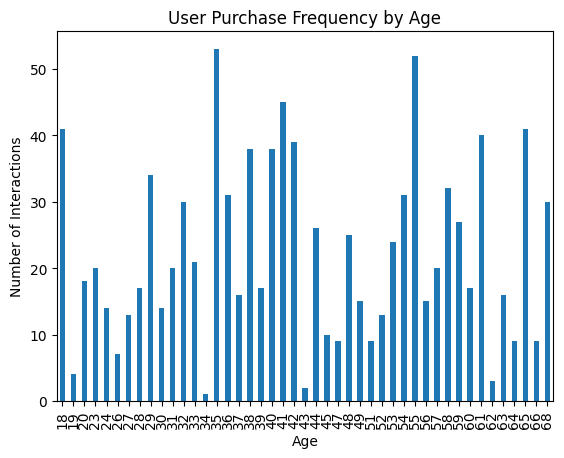

In [9]:

# Visualize product popularity
plt.figure(figsize=(10, 6))
sns.histplot(data=product_data, x='popularity', bins=20, kde=True)
plt.title('Product Popularity Distribution')
plt.show()

# Check interactions by user demographics
user_purchase_freq = data.groupby('age')['interaction'].count()
user_purchase_freq.plot(kind='bar', title='User Purchase Frequency by Age')
plt.xlabel('Age')
plt.ylabel('Number of Interactions')
plt.show()


MODEL DEVELOPMENT

In [10]:
# Ensure 'interaction' is numeric and encoded to prevent issues with pivot
interaction_map = {'view': 1, 'add_to_cart': 2, 'purchase': 3}
data['interaction'] = data['interaction'].map(interaction_map)

# Create a user-item matrix and check if it's populated
user_item_matrix = data.pivot_table(index='user_id', columns='product_id', values='interaction', fill_value=0)

if user_item_matrix.empty:
    raise ValueError("User-item matrix is empty. Check that your data contains valid interactions.")

# Convert to sparse matrix for memory efficiency
user_item_sparse = csr_matrix(user_item_matrix.values)

# Calculate user similarity if matrix is populated
user_similarity = cosine_similarity(user_item_sparse)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# Function to recommend products based on similar users
def recommend_products(user_id, n=5):
    if user_id not in user_similarity_df.index:
        return "User not found in data."
    
    # Get the most similar users and their products
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).index[1:n+1]
    similar_users_products = user_item_matrix.loc[similar_users].sum().sort_values(ascending=False).head(n)
    return similar_users_products.index.tolist()

# Test recommendations for a sample user
sample_recommendations = recommend_products(user_id=1)
print(f"Recommended products for user 1: {sample_recommendations}")


Recommended products for user 1: [1, 30, 40, 42, 9]


MODEL EVALUATION AND TUNING

In [11]:
# Placeholder evaluation function (for simulated data only)
def evaluate_model(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    print(f'Precision: {precision}, Recall: {recall}')


DEVELOPMENT OF API ( CREATING A FLASK API)

In [12]:


app = Flask(__name__)

@app.route('/recommend', methods=['POST'])
def recommend():
    user_id = request.json.get('user_id')
    recs = recommend_products(user_id=user_id, n=5)
    return jsonify({'recommended_products': recs})

if __name__ == '__main__':
    app.run(debug=True, use_reloader=False)


NameError: name 'Flask' is not defined